In [9]:
import os
import numpy as np
import pandas as pd
import nilearn
from nilearn import image as nimage
from nilearn.masking import apply_mask
import neuromaps
from neuromaps.images import (load_nifti, load_data)
from neuromaps.resampling import resample_images
import nibabel as nib
import os
import ants
from ants import image_read, apply_transforms
from nilearn.datasets import fetch_atlas_harvard_oxford
import matplotlib.pyplot as plt

In [ ]:
### Set paths and variables

In [13]:
#structural_path = '/Users/pecsok/Desktop'
#outpath = '/Users/pecsok/Desktop'
nmaps_path = '/Users/pecsok/Desktop/test/outputdfs'
nmaps = ["NMDA","mGluR5","GABA"] 

dataset = '3T'
atlas = 'Schaefer2018_1000Parcels_17Networks'


In [ ]:
# Identify parcels that have enough data. Then create parcel df with parcel rows and multimodal columns.
columns = cest_parcelmat.columns[cest_parcelmat.notnull().sum() > len(cest_parcelmat)*.75]
parcels = [col.split('_')[1] for col in columns if '_' in col]
#print(parcels)
unique_list = list(set(parcels))
seen = set()
unique_list = [x for x in parcels if not 
               (x in seen or seen.add(x))]
print(unique_list)


# Filter df:
def column_to_keep(df, column_name, subj_info, parcels):
    
    if column_name in subj_info:
        return True
    for num in parcels:
        if num in column_name:
            return True
    return False

subj_info =  ["BBLID", "Session"] + diag_scores    
filtered_grp_cols = [col for col in grp_df.columns if column_to_keep(col, subj_info, parcels)]
filtered_cest_cols = [col for col in cest_parcelmat.columns if column_to_keep(col, subj_info, parcels)]

# Create new DataFrame with only the filtered columns
filtered_grp_df = grp_df[filtered_grp_cols]
filtered_cest_parcelmat = cest_parcelmat[filtered_cest_cols]

# Trim GluCEST values based on whether NZCount is high enough
# @Maggie, fix tomorrow. This is skipping some rows. Figure out why.
numbers = [str(i) for i in range(50,101)]
for index, row in filtered_cest_parcelmat.iterrows():
    for num in numbers:
        ctname = 'NZcount_' + num
        avgname= 'NZMean_' + num
        if ctname in filtered_cest_parcelmat.columns:
            if row[ctname] < 20:
                #print(ctname)
                #print(filtered_cest_parcelmat.at[index, ctname])
                filtered_cest_parcelmat.at[index, avgname] = np.nan
                filtered_cest_parcelmat.at[index, ctname] = np.nan
                break


print(filtered_cest_parcelmat)
filtered_grp_df.to_csv('filtered_grp_df' + fieldstrength + atlas + '.csv', index=True)
filtered_cest_parcelmat.to_csv('filtered_cest_parcelmat' + fieldstrength + atlas + '.csv', index=True)

   Unnamed: 0      Subject  501.0_Mean  501.0_Count  502.0_Mean  502.0_Count  \
0           0  20303_12234   -0.414982           40    0.945605           78   
1           1  90217_12230   -0.199067           25    0.880621           43   
2           2  88608_12108    0.141422           22    0.695221           46   

   504.0_Mean  504.0_Count  516.0_Mean  516.0_Count  ...  568.0_Mean  \
0   -0.015522           97   -0.707738            1  ...         NaN   
1    0.451514           32   -0.056900           15  ...         NaN   
2    0.409983           65    0.411600            5  ...    0.841293   

   568.0_Count  614.0_Mean  614.0_Count  615.0_Mean  615.0_Count  616.0_Mean  \
0          NaN         NaN          NaN         NaN          NaN         NaN   
1          NaN         NaN          NaN         NaN          NaN         NaN   
2         14.0    0.071426         24.0    -0.08734          5.0   -0.093973   

   616.0_Count  682.0_Mean  682.0_Count  
0          NaN         NaN 

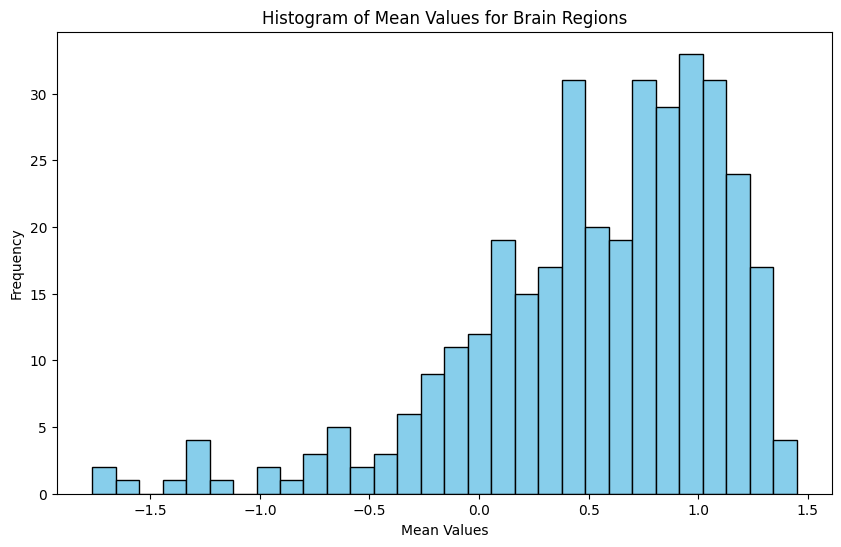

   Unnamed: 0      Subject  501.0_Mean  501.0_Count  502.0_Mean  502.0_Count  \
0           0  20303_12234    0.154076           40    1.796738           78   
1           1  90217_12230    0.420650           25    1.657978           43   
2           2  88608_12108    0.485699           22    1.755396           46   

   504.0_Mean  504.0_Count  516.0_Mean  516.0_Count  ...  568.0_Mean  \
0    0.570998           97    0.607436            1  ...         NaN   
1    0.911577           32    0.817924           15  ...         NaN   
2    0.687276           65    0.901732            5  ...    1.201606   

   568.0_Count  614.0_Mean  614.0_Count  615.0_Mean  615.0_Count  616.0_Mean  \
0          NaN         NaN          NaN         NaN          NaN         NaN   
1          NaN         NaN          NaN         NaN          NaN         NaN   
2         14.0   -0.132746         24.0    0.169892          5.0    0.175636   

   616.0_Count  682.0_Mean  682.0_Count  
0          NaN         NaN 

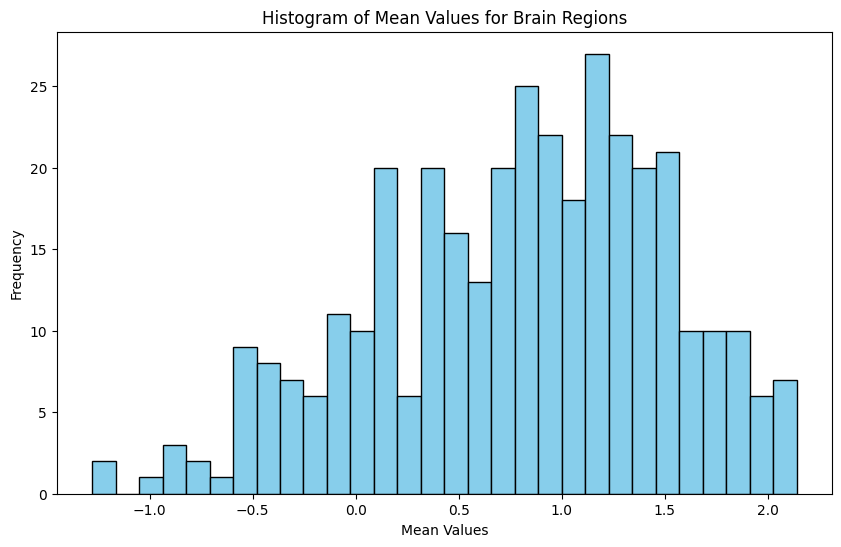

   Unnamed: 0      Subject  501.0_Mean  501.0_Count  502.0_Mean  502.0_Count  \
0           0  20303_12234   -0.024362           40    0.633206           78   
1           1  90217_12230    0.079087           25    0.559476           43   
2           2  88608_12108    0.099667           22    0.569411           46   

   504.0_Mean  504.0_Count  516.0_Mean  516.0_Count  ...  568.0_Mean  \
0    0.269855           97   -0.457152            1  ...         NaN   
1    0.384690           32   -0.398463           15  ...         NaN   
2    0.280445           65   -0.213176            5  ...    0.810045   

   568.0_Count  614.0_Mean  614.0_Count  615.0_Mean  615.0_Count  616.0_Mean  \
0          NaN         NaN          NaN         NaN          NaN         NaN   
1          NaN         NaN          NaN         NaN          NaN         NaN   
2         14.0   -0.136178         24.0    0.185224          5.0    0.151875   

   616.0_Count  682.0_Mean  682.0_Count  
0          NaN         NaN 

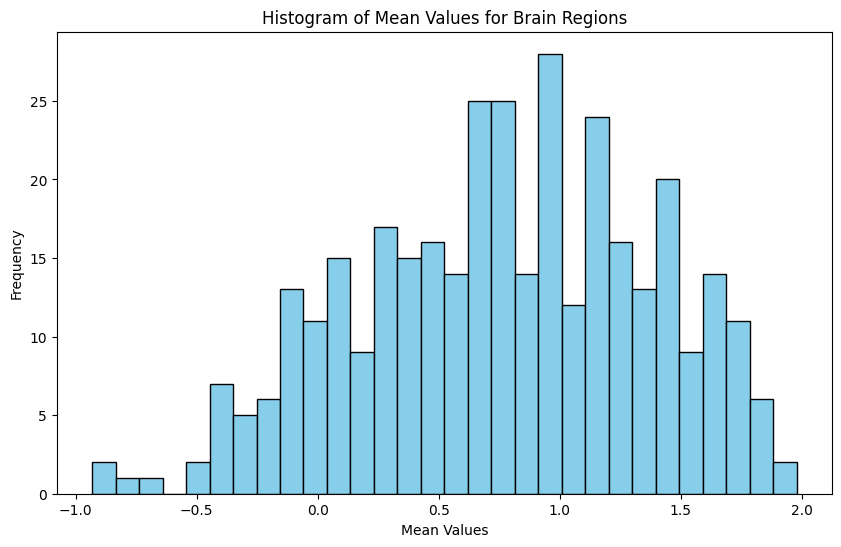

In [12]:
for nmap in nmaps:
    path = os.path.join(nmaps_path, nmap + '_data_' + dataset + atlas + '.csv')
    nmap_df = pd.read_csv(path)
    print(nmap_df)

    meancols = nmap_df.filter(like="Mean")
    melted = meancols.melt()

    plt.figure(figsize=(10, 6))
    plt.hist(melted['value'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Histogram of Mean Values for Brain Regions')
    plt.xlabel('Mean Values')
    plt.ylabel('Frequency')
    plt.show()
